# Project


### Libraries


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf)
import os
import imageio

### Helper Functions

In [ ]:
def log_sum_exp(x):
    """ Stable log sum exp implementation """
    x_max = np.max(x)
    return x_max + np.log(np.sum(np.exp(x - x_max)))

def plot_heat_map(M, title):
  plt.imshow(M, origin='lower', cmap='hot', interpolation='nearest')
  plt.colorbar(label='Probability')
  plt.title(title)
  plt.xlabel('State x-coordinate')
  plt.ylabel('State y-coordinate')
  # Setting the ticks on both axes
  plt.xticks(np.arange(10), labels=np.arange(10))
  plt.yticks(np.arange(10), labels=np.arange(10))
  plt.show()

### Map

In [ ]:
class Map:
  def __init__(self, size, start, obstacles=None):
    """
    Initialize a grid map.

    Parameters:
      size (tuple): A tuple representing the dimensions of the grid (columns, rows).
      start (tuple): The starting cell coordinates (column, row).
      obstacles (list of tuples): Obstacle definitions as (start_column, start_row, width, height).
    """
    self.size = size
    self.robot = start
    self.cells = np.zeros(size)
    self.obstacles = []
    if obstacles:
      self.process_obstacles(obstacles)

  def process_obstacles(self, obstacles):
    """
    Process a list of obstacle definitions to populate the obstacle coordinates.

    Parameters:
      obstacles (list of tuples): Obstacle definitions as (start_column, start_row, width, height).
    """
    for (start_col, start_row, width, height) in obstacles:
      for i in range(start_row, start_row + height):
        for j in range(start_col, start_col + width):
          if 0 <= i < self.size[1] and 0 <= j < self.size[0]:
            self.obstacles.append((j, i))

  def is_obstacle(self, position):
    """
    Check if a specified position is an obstacle.

    Parameters:
      position (tuple): The position to check, specified as (column, row).

     Returns:
      bool: True if the position is an obstacle, False otherwise.
    """
    return position in self.obstacles

  def is_out_of_bounds(self, position):
    """
    Determine if a specified position is out of the map boundaries.

    Parameters:
      position (tuple): The position to check, specified as (column, row).

    Returns:
      bool: True if the position is out of bounds, False otherwise.
    """
    x, y = position
    return x < 0 or y < 0 or x >= self.size[0] or y >= self.size[1]

  def is_valid_state(self, state):
    """
    Check if a state is valid (within the map boundaries and not an obstacle).

    Parameters:
      - state (tuple): The state to check, specified as (column, row).

    Returns:
      - bool: True if the state is valid, False otherwise.
    """
    if self.is_out_of_bounds(state) or self.is_obstacle(state):
      return False
    return True

  def position_to_idx(self, position):
    """
    Convert a grid cell position to a corresponding index in a list.

    Parameters:
      position (tuple): The grid position specified as (column, row).

    Returns:
      int: The list index corresponding to the position.
    """
    col, row = position
    return row * self.size[0] + col

  def idx_to_position(self, idx):
    """
    Convert an index in a list to a map position.

    Parameters:
      idx (int): The index in the list.

    Returns:
      tuple: The map position as (column, row).
    """
    col = idx % self.size[0]
    row = idx // self.size[0]
    return (col, row)

  def plot(self, legend=True, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    color_map = np.zeros(self.size, dtype=int)
    color_map[self.robot[1], self.robot[0]] = 1
    for obstacle in self.obstacles:
        color_map[obstacle[1], obstacle[0]] = 2

    cmap = plt.get_cmap('viridis', 3)
    colors = cmap(np.arange(3))
    colors[0] = [1.0, 1.0, 1.0, 1.0]
    colors[1] = [0.0, 0.0, 1.0, 1.0]
    colors[2] = [0.5, 0.5, 0.5, 1.0]
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    ax.imshow(color_map, cmap=cmap, origin='lower')
    if legend:
        cbar = plt.colorbar(ax.imshow(color_map, cmap=cmap, origin='lower'), ax=ax, ticks=[0, 1, 2])
        cbar.set_ticklabels(['Unoccupied', 'Robot', 'Obstacle'])

    ax.set_xticks(np.arange(0, self.size[0]))
    ax.set_yticks(np.arange(0, self.size[1]))
    ax.set_xticklabels(np.arange(self.size[0]))
    ax.set_yticklabels(np.arange(self.size[1]))
    ax.grid(True, which='minor', color='k', linestyle='-', linewidth=2)
    ax.set_title('Map')


### Motion Model


In [ ]:
class MotionModel:
  def __init__(self):
    """
    Initializes a MotionModel object with predefined actions and their associated probabilities.

    Attributes:
      - actions (list): A list of possible actions ('N', 'E', 'S', 'W').
      - action_probs (dict): A dictionary mapping each action to a list of tuples, where each tuple
      contains an action and its corresponding probability. This setup includes probabilities
      for intended movements and deviations.
    """
    self.actions = ['N', 'E', 'S', 'W']
    self.action_probs = {
        'N': [('N', 0.6), ('W', 0.1), ('S', 0.1), ('E', 0.1)],
        'W': [('W', 0.6), ('S', 0.1), ('E', 0.1),('N', 0.1)],
        'S': [('S', 0.6), ('E', 0.1), ('N', 0.1), ('W', 0.1)],
        'E': [('E', 0.6), ('N', 0.1), ('W', 0.1), ('S', 0.1)],
    }

  def get_next_state(self, map, state, action):
    """
    Determines the next state based on the current state and an action.

    Parameters:
      - map (Map): The map object that includes methods to check state validity.
      - state (tuple): The current state as (column, row).
      - action (str): The action to be taken.

    Returns:
      - tuple: The next state as (column, row), or the current state if movement is invalid.
    """
    col, row = state
    action_offset = {'N': (0, 1), 'W': (-1, 0), 'S': (0, -1), 'E': (1, 0)}
    next_state = (col + action_offset[action][0], row + action_offset[action][1])

    if map.is_valid_state(next_state):
        return next_state
    else:
        return state

  def init_transitions(self, map):
    """
    Initializes the transition matrix based on the map and the defined action probabilities.

    Parameters:
      - map (Map): The map object which defines the grid and provides utility functions such as
      checking for obstacles and converting state indices.

    Notes:
      This function calculates the transition probabilities between states for each action,
      considering the possibility of staying in the current state if the movement to a new state
      is invalid (e.g., due to obstacles or edges of the map).
    """
    action_probs = self.action_probs
    cols, rows = map.size
    num_states = rows * cols
    num_actions = len(self.actions)
    transitions = np.zeros((num_states, num_states, num_actions))
    stay_prob = 0.1  # Probability of not moving to a new state

    for state_index in range(num_states):
      state_map = map.idx_to_position(state_index)
      # Skip obstacle states
      if map.is_obstacle(state_map):
        continue
      # Compute transition probabilities for non-obstacle states
      for action_index, action in enumerate(self.actions):
        action_probs = self.action_probs[action]

        # Calculate transition probabilities for all potential next actions
        for next_action, prob in action_probs:
          next_state_map = self.get_next_state(map, state_map, next_action)
          next_state_index = map.position_to_idx(next_state_map)
          transitions[state_index, next_state_index, action_index] += prob

        # Include the probability of not moving from the current state
        transitions[state_index, state_index, action_index] += stay_prob
    self.T = transitions

### Sensor Model

 Observation matrix formula : What is probability of recieving observation M given the current state.

In [ ]:
class SensorModel:
  def __init__(self, map, sensor_accuracy = 0.95):
    """
    Initializes a SensorModel that creates a set of sensor observation probability matrices based on the map's layout.

    Parameters:
      - map (Map): The map object that includes information about the environment, such as obstacles and valid state spaces.
      - sensor_accuracy (float): The probability that the sensor correctly identifies an obstacle if there is one.

    Attributes:
      - sensor_accuracy (float): Stores the sensor accuracy.
      - M (dict): A dictionary mapping each possible sensor observation configuration
      (tuples of booleans representing obstacle detections in the order [North, West, South, East]) to its corresponding
      probability matrix which reflects the likelihood of each observation given each state in the map.
    """
    self.sensor_accuracy = sensor_accuracy
    self.M = self.init_probabilities(map)


  def init_probabilities(self, map):
    """
    Generates a dictionary of probability matrices for each possible sensor observation configuration.
    Each matrix provides the probabilities of observing a particular configuration from each state in the map.

    Parameters:
      - map (Map): The map object which is used to check the validity and characteristics of states.

    Returns:
      - dict: A dictionary where keys are observation tuples (True/False values indicating obstacle detection in
      the North, West, South, and East directions) and values are the probability matrices (2D numpy arrays).
      Each matrix is normalized such that all elements sum to 1.
    """
    cols, rows = map.size
    num_states = cols * rows
    observations_probs = {}
    for north in [True, False]:
      for west in [True, False]:
        for south in [True, False]:
          for east in [True, False]:
            ### Commpute Probability Matrix for Single Observation ###
            observation = (north, west, south, east)
            prob_matrix = np.zeros((cols, rows))
            for i in range(cols):
              for j in range(rows):
                current_state = (i, j)
                if not map.is_valid_state(current_state): # Skip invalid states
                  continue
                probs = []
                for direction, obs in zip([(0, 1), (-1, 0), (0, -1), (1, 0)], observation):
                  di, dj = direction
                  ni, nj = i + di, j + dj
                  if map.is_valid_state((ni, nj)):  # Free cell
                    prob = self.sensor_accuracy if not obs else 1 - self.sensor_accuracy  # Perfect detection of free cells
                  else:  # Obstacle or out of bounds
                    prob = self.sensor_accuracy if obs else 1 - self.sensor_accuracy
                  probs.append(prob)
                prob_matrix[current_state] = np.prod(probs)
            ### End Commpute Probability Matrix for Single Observation ###

            ### Save Observation's Probability Matrix to Dictionary ###
            normalizing_constant = np.sum(prob_matrix)
            observations_probs[observation] = prob_matrix.T
            if normalizing_constant != 0:
              observations_probs[observation] /= normalizing_constant
            ### End Save Observation's Probability Matrix to Dictionary ###
    return observations_probs

### HMM


In [ ]:
class HMM:
  def __init__(self, observations, control_inputs, observation_probs, transition_probs):
    """
    Initializes the Hidden Markov Model with necessary parameters and state variables.

    Parameters:
      - observations (list of tuples): Each tuple represents the detection (True/False) of an obstacle in
      the North (N), West (W), South (S), and East (E) directions. So, (N, W, S, E) touples.
      - control_inputs (list): A list of action commands that were given to the robot at each time step,
      corresponding to one of the four cardinal directions: N, W, S, or E.
      - observation_probs (dict): A dictionary mapping each possible observation (tuple of four booleans)
      to the observation probability matrix for each state.
      - transition_probs (numpy array): A 3D array where each slice (num_statesxnum_states) corresponds to the transition
      probabilities between all pairs of states under a specific action (N, W, S, E).

    Attributes:
      - N (int): Number of states.
      - num_obs (int): Number of observations.
      - T (numpy array): Transition probabilities.
      - M (dict): Observation probabilities.
      - observations (list): Recorded observations.
      - u (list): Control inputs.
      - alpha (numpy array): Forward probabilities.
      - betta (numpy array): Backward probabilities.
      - gamma (numpy array): Smoothing probabilities.
    """
    self.N = transition_probs.shape[0]
    self.num_obs = len(observations)
    self.T = transition_probs
    self.M = observation_probs
    self.u = control_inputs
    self.observations = observations
    self.alpha = np.zeros((transition_probs.shape[0], len(observations)))
    self.beta = np.zeros((transition_probs.shape[0], len(observations)))
    self.gamma = np.zeros((transition_probs.shape[0], len(observations)))

  def forward(self):
    """
    Implements the forward algorithm to compute the forward probabilities for each state over time,
    updating beliefs based on observed data.
    """
    # Initialize the first column of forward probabilities with equal distribution
    M_0 = self.M[self.observations[0]].reshape((1, self.N))
    self.alpha[:, 0] = (np.ones(self.N) / self.N) * M_0

    for t in range(1, self.num_obs):
      M = self.M[self.observations[t]].reshape((1, self.N))  # Get observation probabilities as 1xN
      T = self.T[:, :, self.u[t-1]]  # Get the transition matrix for the given control input at time t-1, NxN
      prior = self.alpha[:, t - 1].reshape((1, self.N))  # prior probabilities, 1xN
      self.alpha[:, t] = (prior @ T * M)  # Compute new probabilities, Nx1
      #self.alpha[:, t] /= np.sum(self.alpha[:, t])  # Normalize each column after computation

  def backward(self):
    """
    Implements the backward algorithm to compute and store the backward probabilities (beta) for each state over time.
    Initializes with the last time step and iteratively updates probabilities moving backwards.
    """
    # Initialize the last column of backward probabilities to 1
    self.beta[:, self.num_obs - 1] = np.ones(self.N)

    # Move backwards from T-1 to 0
    for t in range(self.num_obs - 2, -1, -1):
        M = (self.M[self.observations[t + 1]].reshape(1, self.N)).T  # Observation probabilities at t+1, reshaped to Nx1
        T = self.T[:, :, self.u[t]]  # Transition probabilities for the control input at t
        self.beta[:, t] = (T @ (self.beta[:, t + 1] * M[:, 0]))  # Update backward probabilities
        #self.beta[:, self.num_obs - 1] /= np.sum(self.beta[:, self.num_obs - 1])

  def smoothing(self):
    """
        Computes the smoothed probabilities (gamma) over time using the collected forward (alpha) and backward (beta)
        probabilities. Normalizes using the sum of alpha probabilities at the last time step.
        """
    smoothed_probabilities = np.zeros((self.N, self.num_obs))  # Initialize smoothed probabilities matrix

    # Compute the normalization constant using the sum of the alphas at each time step
    nu = np.sum(self.alpha[:, -1], axis=0)

    # Calculate smoothed probabilities
    for t in range(self.num_obs):
      self.gamma[:, t] = (self.alpha[:, t] * self.beta[:, t]) / nu

  def run(self):
    self.forward()
    self.backward()
    self.smoothing()

### Testing

1. Map

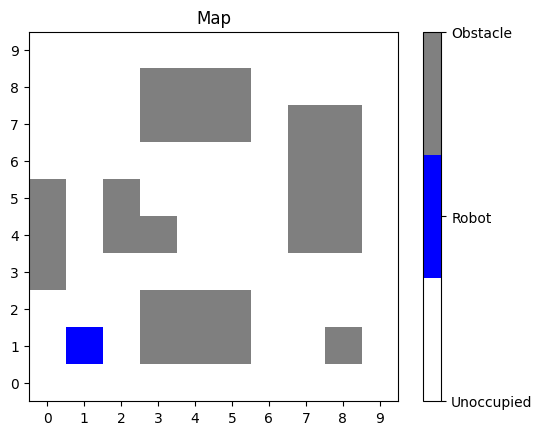

In [ ]:
size = (10, 10)
start = (1, 1)
obstacles = ((0, 3, 1, 3), (2, 4, 2, 1), (2, 5, 1, 1), (3, 1, 3, 2), (3, 7, 3 , 2), (7, 4, 2, 4), (8, 1, 1, 1), )
map = Map(size, start, obstacles)
map.plot()

2. Motion Model

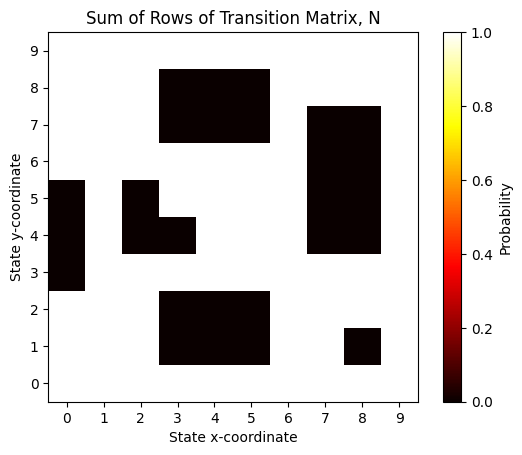

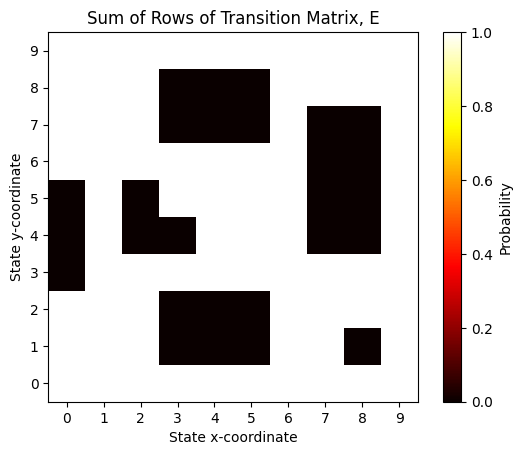

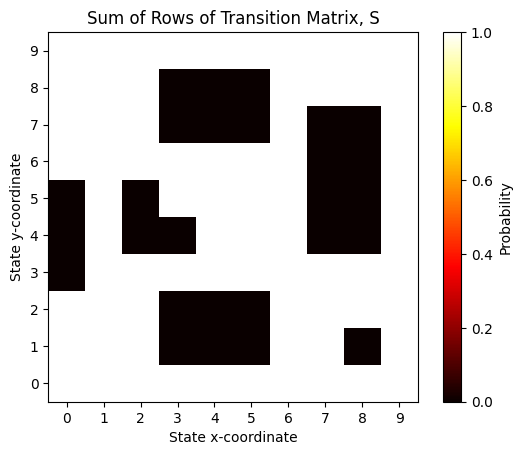

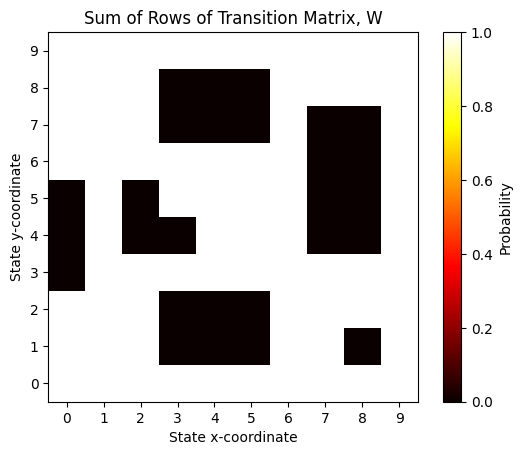

In [ ]:
motion_model = MotionModel()
motion_model.init_transitions(map)
for i, direction in enumerate(motion_model.actions):
  T = motion_model.T[:,:,i]
  plot_heat_map(np.sum(T, axis = 1).reshape(10, 10), "Sum of Rows of Transition Matrix, " + direction)

3. Sensor Model

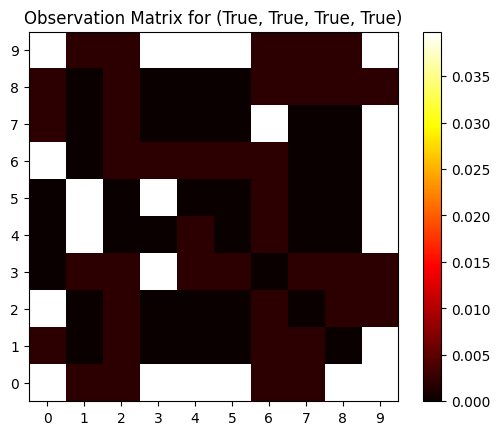

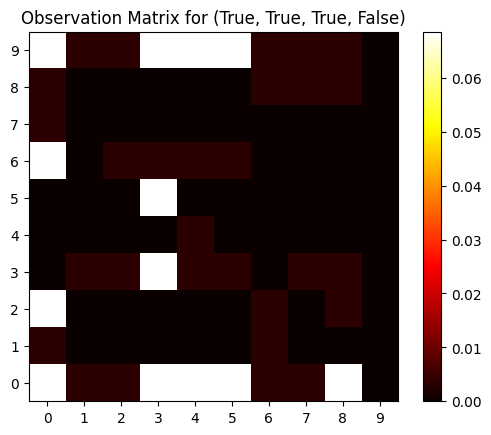

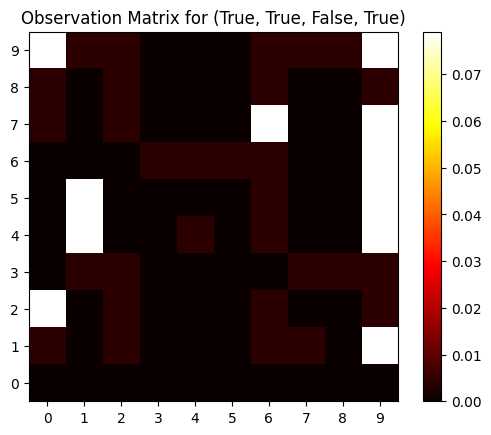

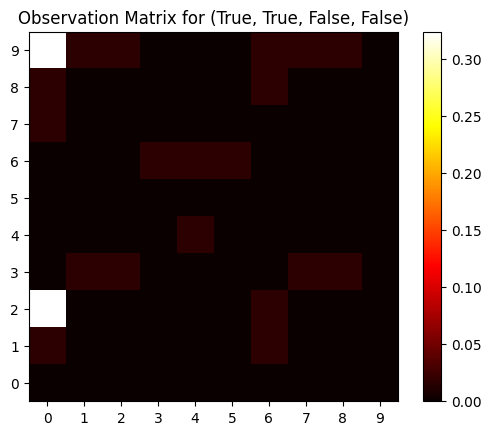

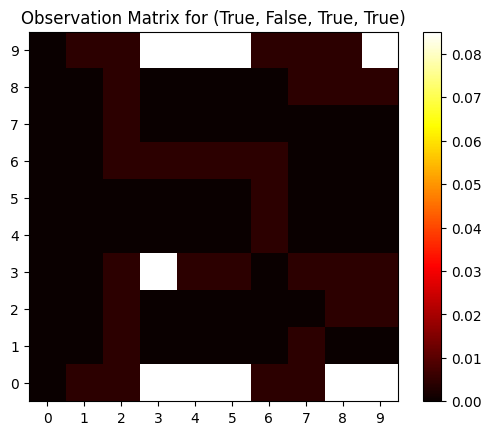

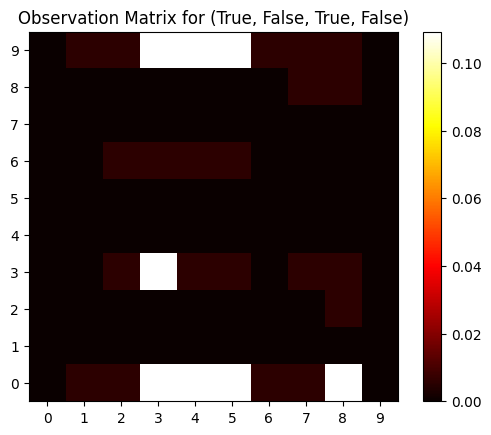

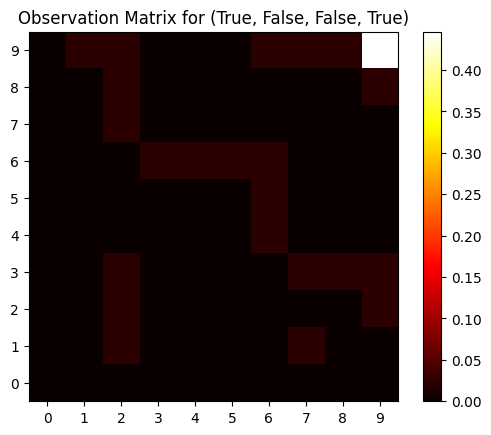

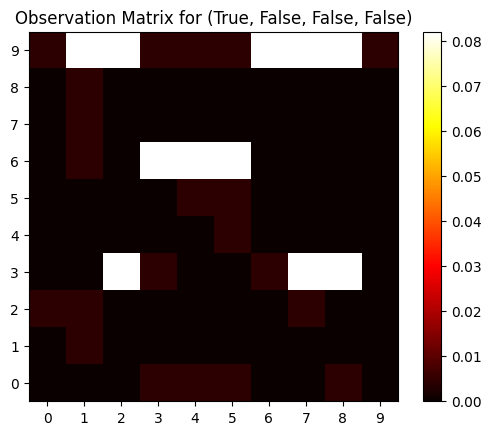

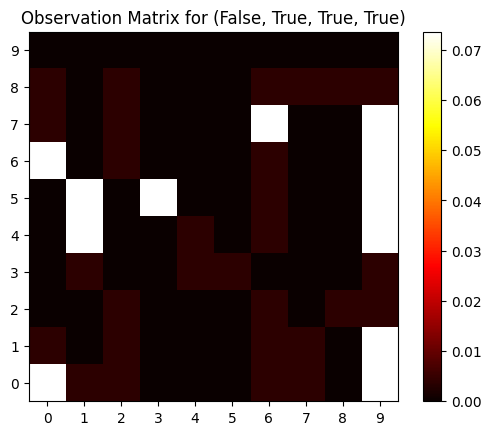

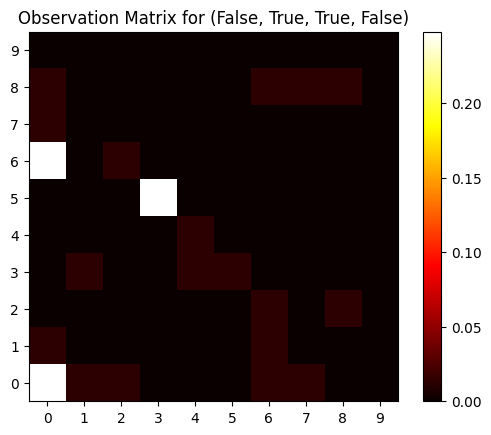

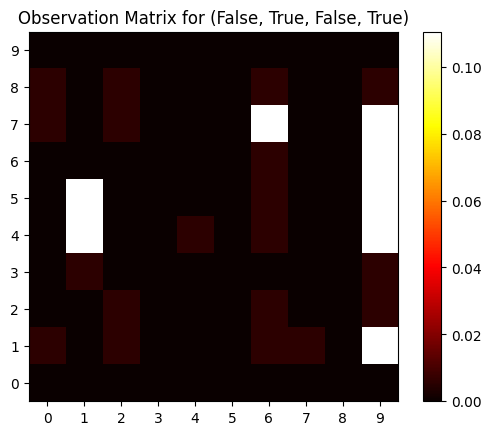

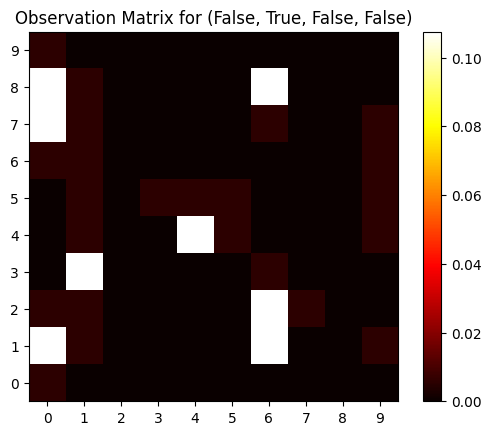

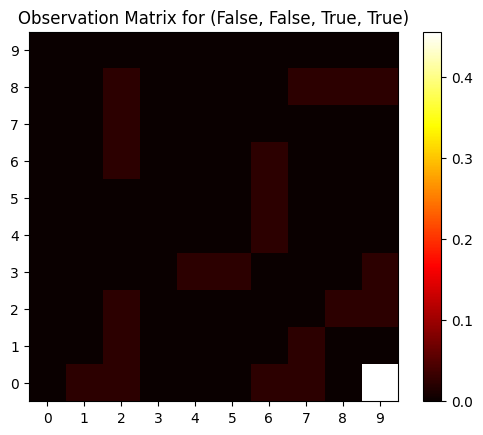

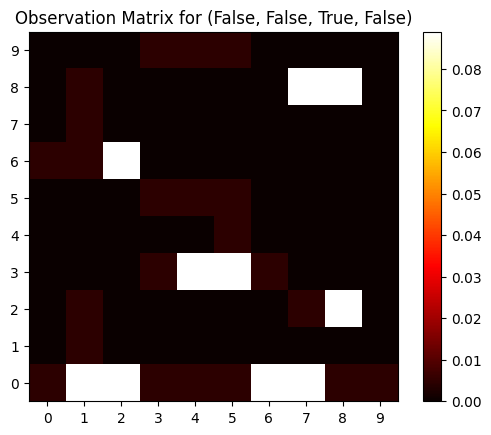

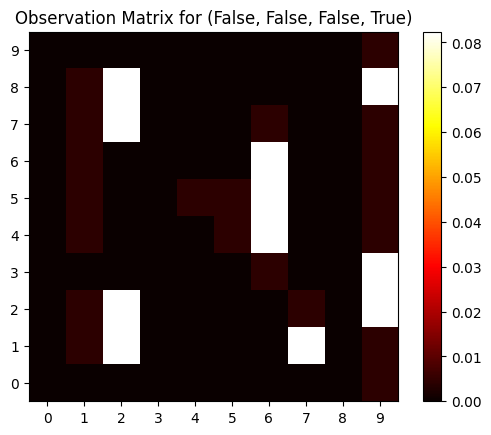

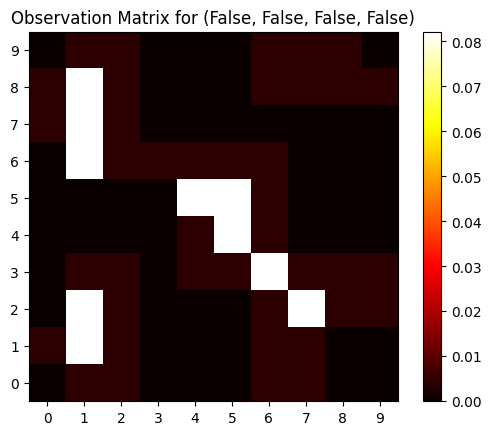

In [ ]:
sensor_model = SensorModel(map)

# Iterate over each observation key in the dictionary
for observation in sensor_model.M.keys():
    z = sensor_model.M[observation]
    plt.figure()
    plt.imshow(z, cmap='hot', interpolation='nearest', origin='lower')
    plt.colorbar()
    plt.title(f"Observation Matrix for {observation}")
    # Setting the ticks on both axes
    plt.xticks(np.arange(10), labels=np.arange(10))
    plt.yticks(np.arange(10), labels=np.arange(10))
    # plt.savefig(f"Observation_Matrix_{observation}.png")
    plt.show()

4. HMM

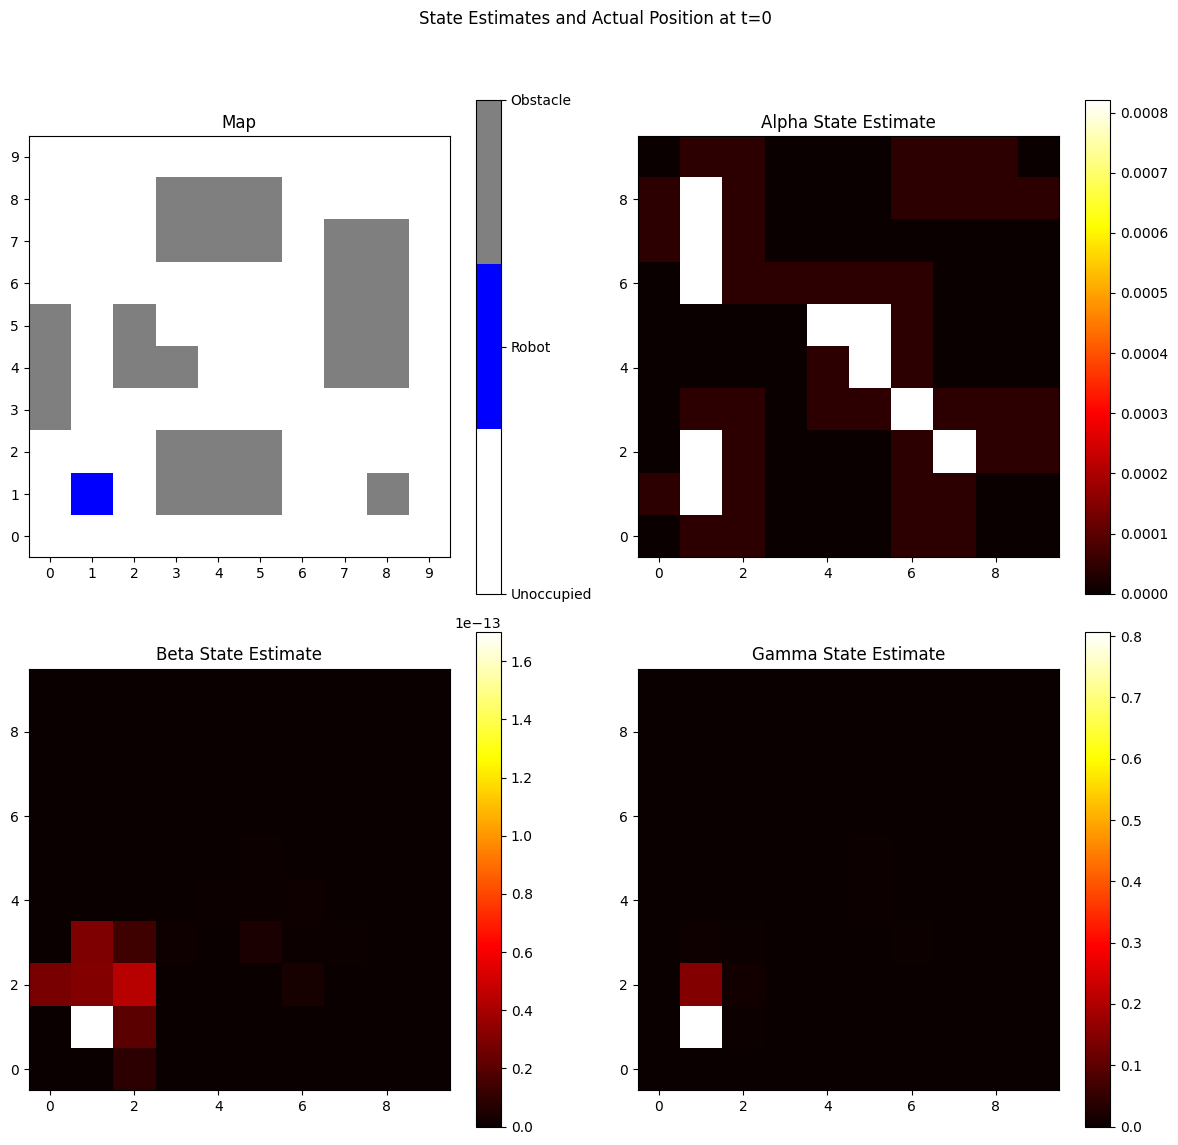

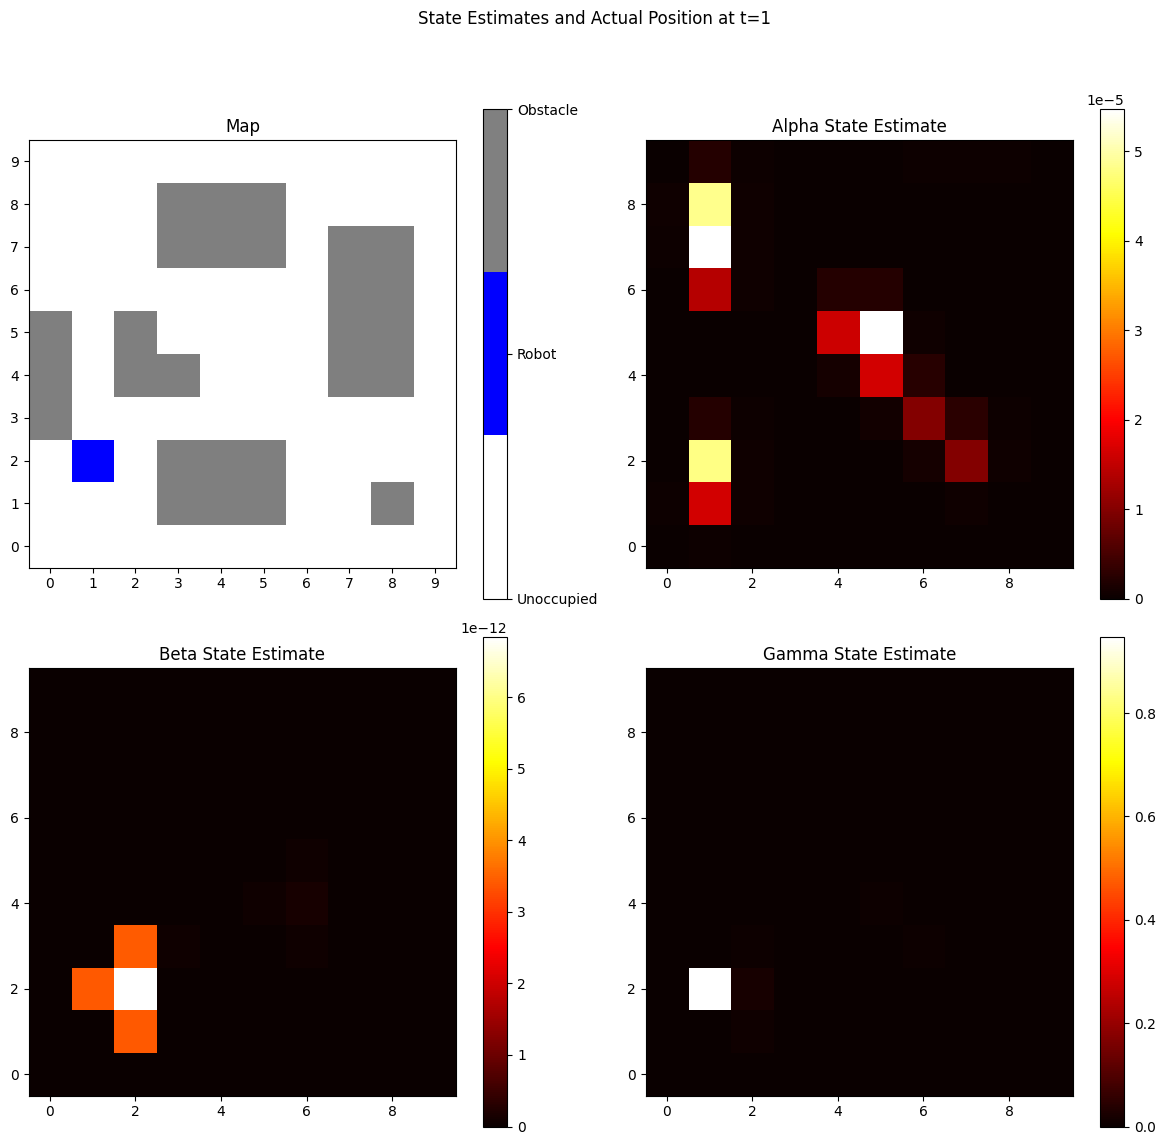

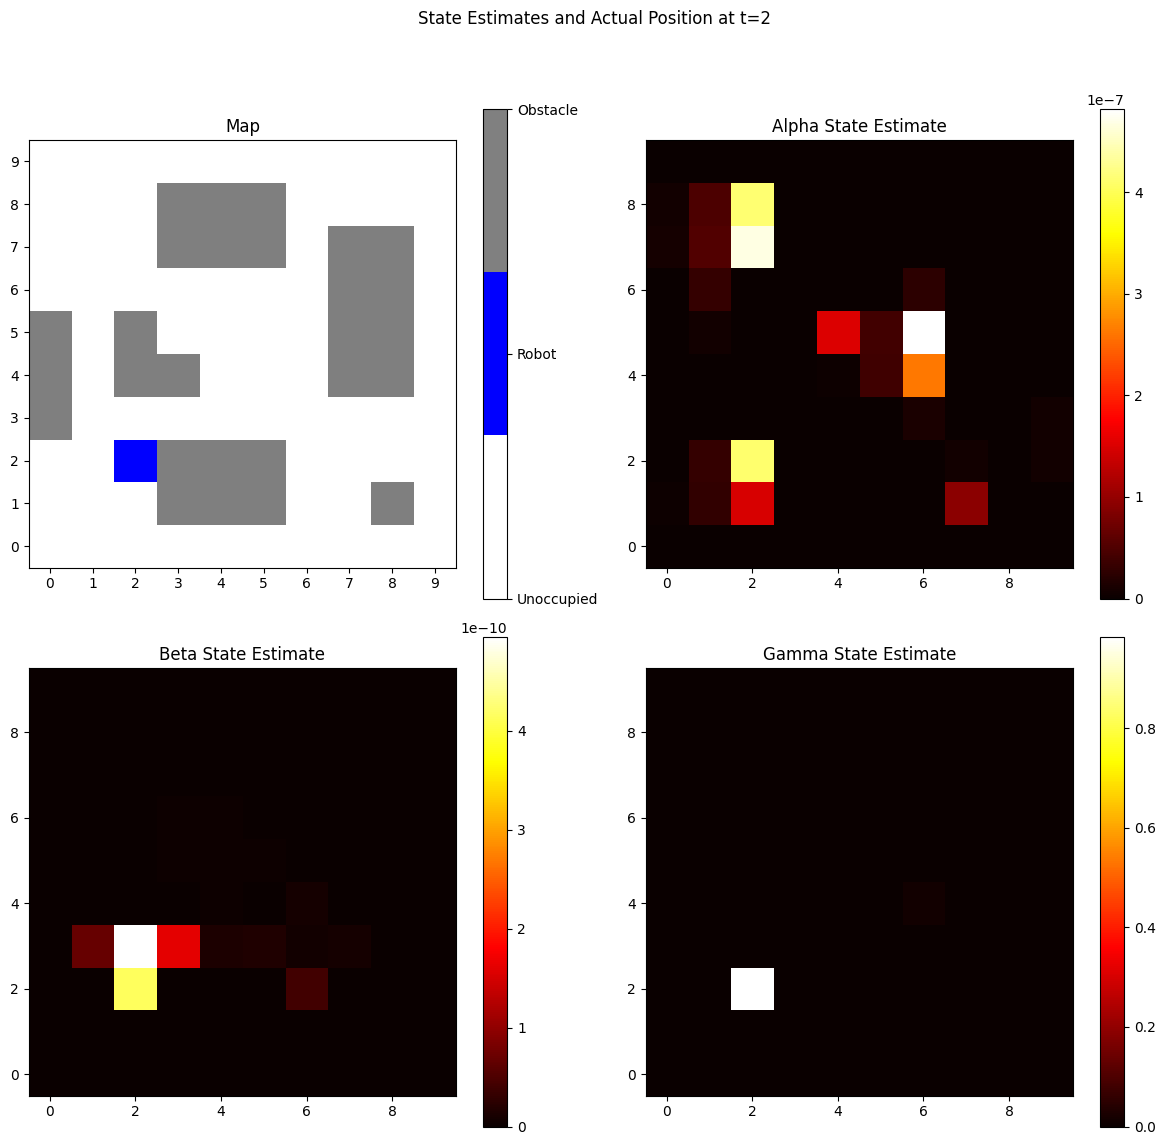

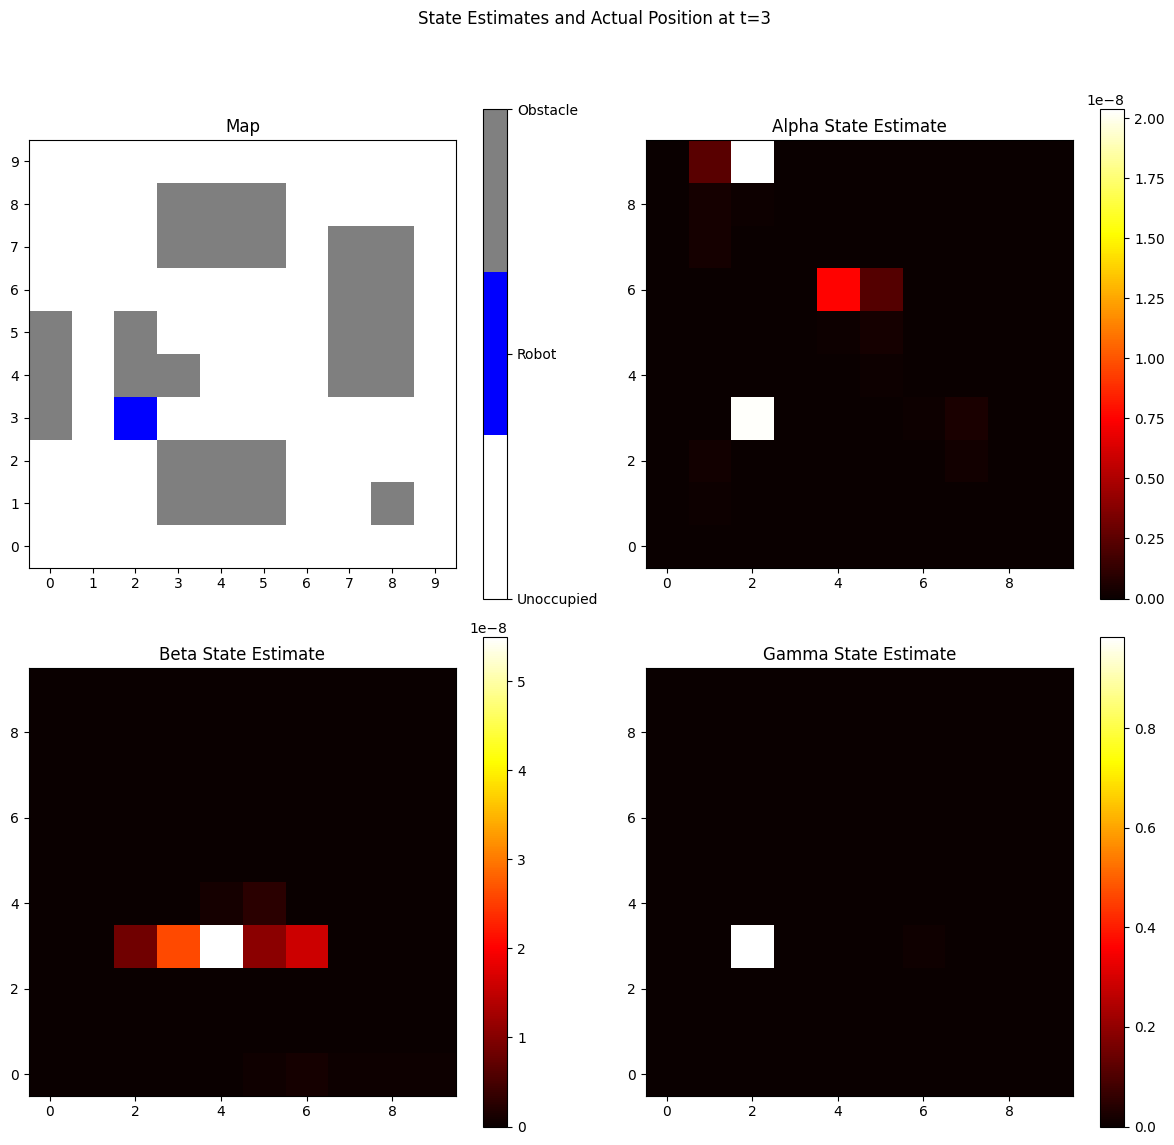

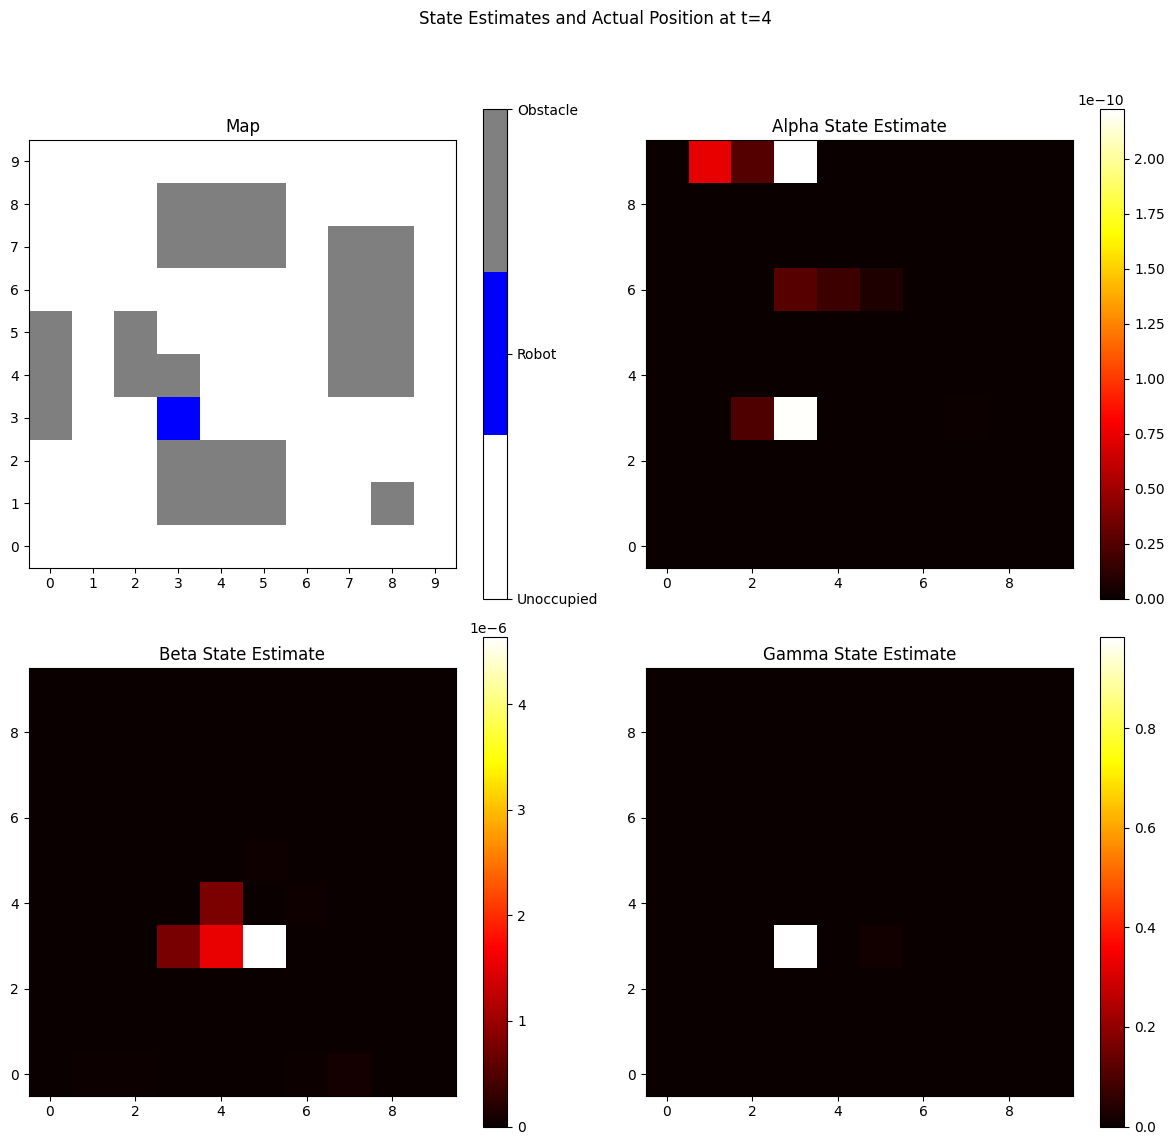

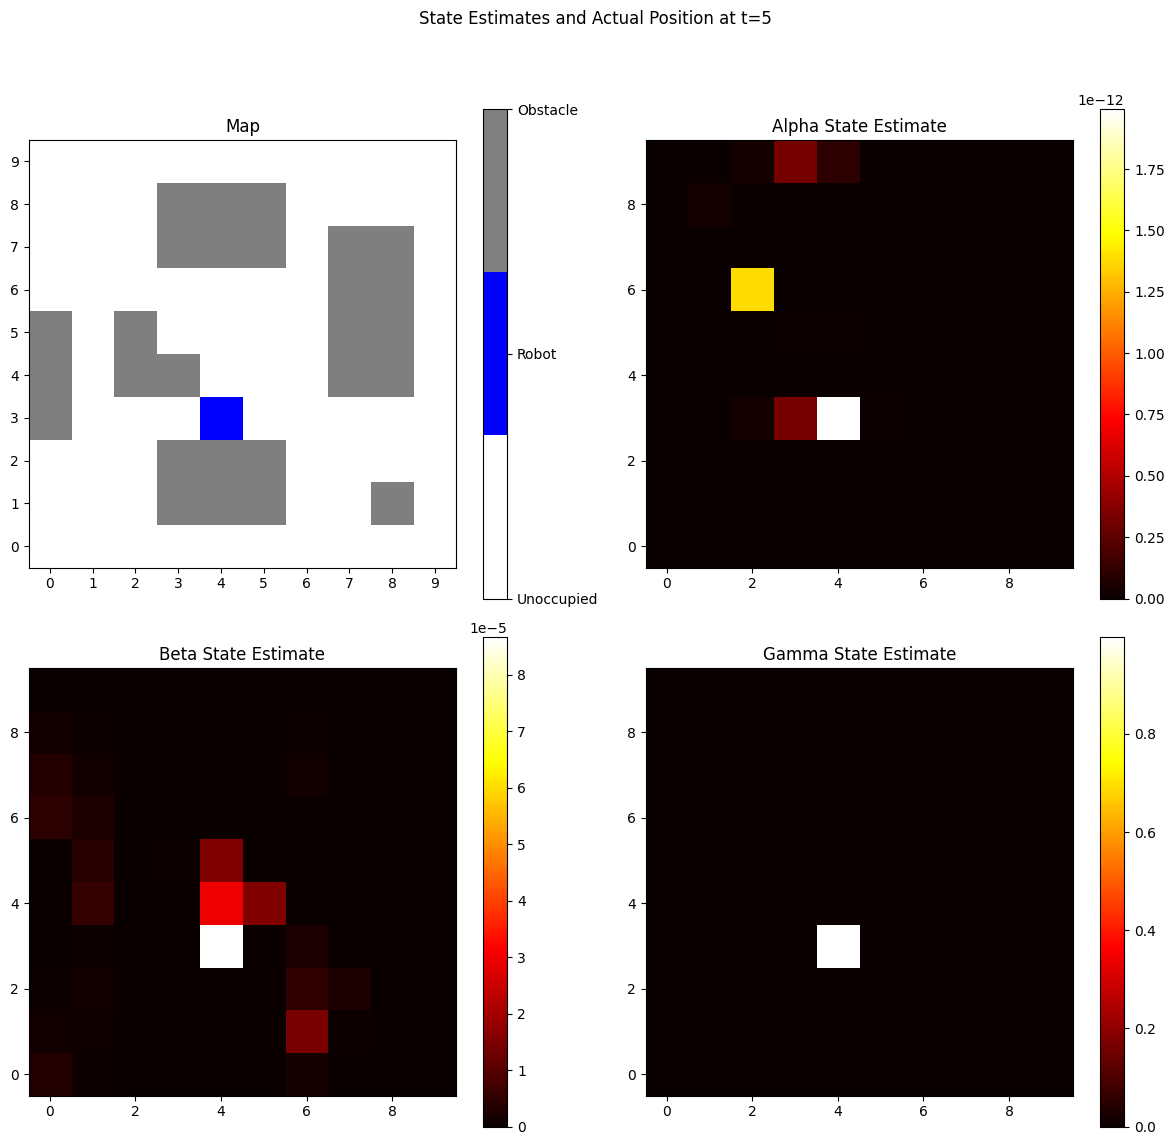

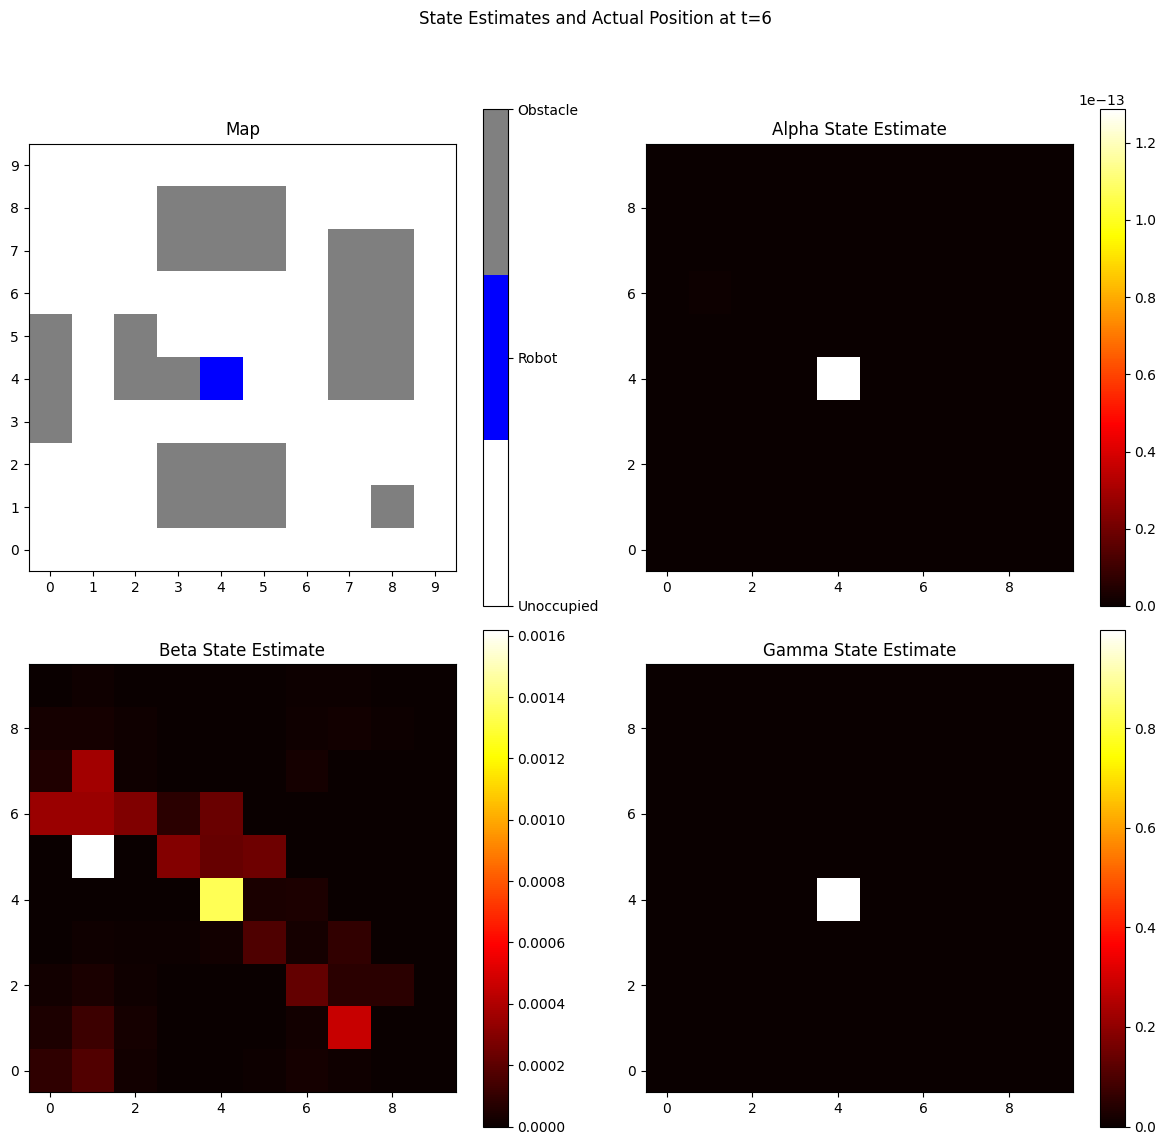

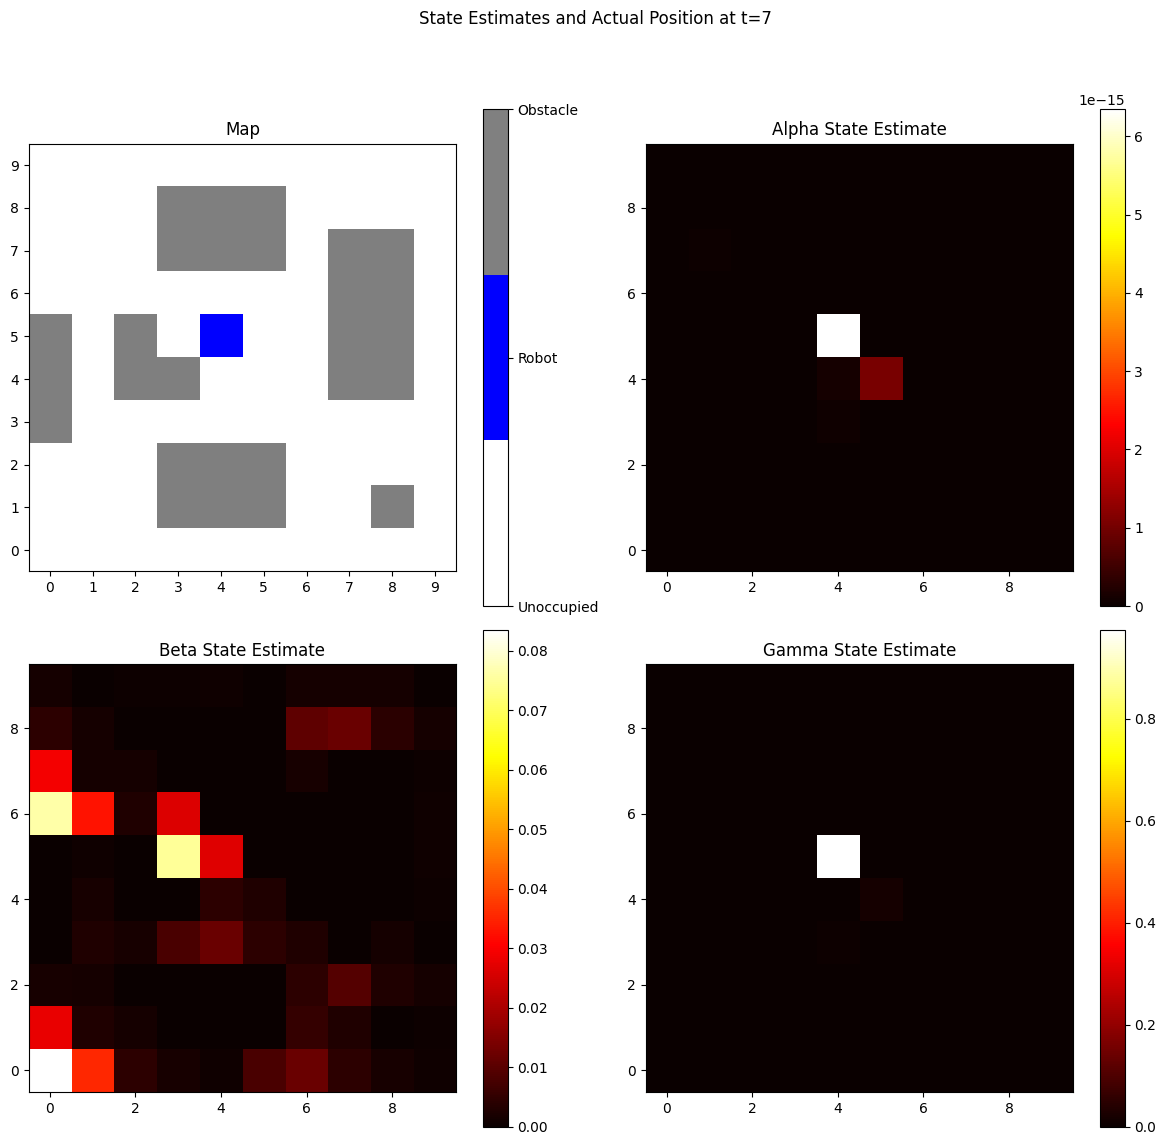

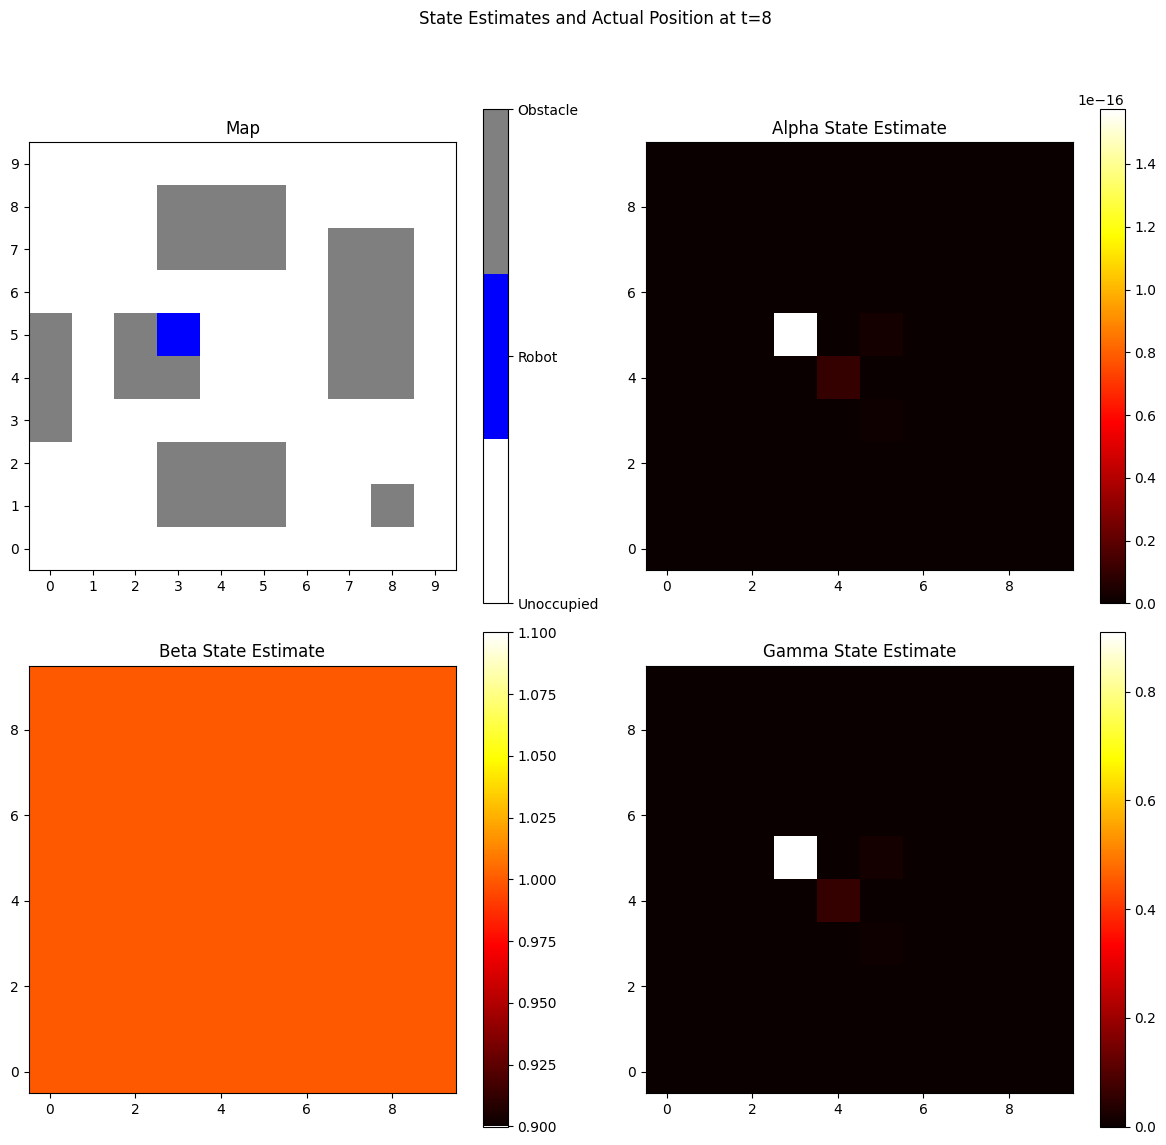

In [ ]:
import matplotlib.pyplot as plt

observations =[(False, False, False, False), (False, False, False, False), (False, False, False, True),
               (True, False, False, False), (True, False, True, False), (False, False, True, False),
               (False, True, False, False), (False, False, False, False), (False, True, True, False)]
actions = [0, 3, 0, 3, 3, 0, 0, 1]
hmm = HMM(observations, actions, sensor_model.M, motion_model.T)
hmm.run()

robot_trajectory = [(1, 1), (1, 2), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (4, 5), (3, 5)]


import matplotlib.pyplot as plt

# Iterate through each timestep
for t in range(9):
    map.robot = robot_trajectory[t]  # Update the robot's position on the map

    ### Estimated Robot Position States ###
    state_est = hmm.alpha[:, t].reshape(10, 10)
    state_est_gamma = hmm.gamma[:, t].reshape(10, 10)
    state_est_beta = hmm.beta[:, t].reshape(10, 10)

    # Setup figure and subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # Create a figure with a 2x2 grid of axes.
    fig.suptitle(f"State Estimates and Actual Position at t={t}")  # Set the main title for the figure

    # Plot Actual Map in the first subplot
    axs[0, 0].set_title("Actual Robot Position")
    map.plot(ax=axs[0, 0])  # Use the custom map plotting function on the specified Axes

    # Plot Alpha state estimate
    im = axs[0, 1].imshow(state_est, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=axs[0, 1])
    axs[0, 1].set_title("Alpha State Estimate")

    # Plot Beta state estimate
    im = axs[1, 0].imshow(state_est_beta, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=axs[1, 0])
    axs[1, 0].set_title("Beta State Estimate")

    # Plot Gamma state estimate
    im = axs[1, 1].imshow(state_est_gamma, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=axs[1, 1])
    axs[1, 1].set_title("Gamma State Estimate")

    # Adjust layout and display the figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.savefig(f"{t}.png")
    plt.show()



### GIFs for the presentation

In [ ]:
# Ensure the plot_frames directory exists
if not os.path.exists('plot_frames'):
    os.makedirs('plot_frames')

hmm = HMM(observations, actions, sensor_model.M, motion_model.T)
hmm.run()

filenames = []  # Filenames for the frames

for t in range(9):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle(f"State Estimates and Actual Position at t={t}")

    # Plot actual robot map
    axs[0, 0].set_title("Actual Robot Position")
    map.robot = robot_trajectory[t]
    map.plot(ax=axs[0, 0], legend = False)  # Plot without legend for cleaner appearance

    # Alpha state estimate
    state_est = hmm.alpha[:, t].reshape(10, 10)
    im = axs[0, 1].imshow(state_est, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=axs[0, 1])
    axs[0, 1].set_title("Alpha State Estimate")

    # Beta state estimate
    state_est_beta = hmm.beta[:, t].reshape(10, 10)
    im = axs[1, 0].imshow(state_est_beta, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=axs[1, 0])
    axs[1, 0].set_title("Beta State Estimate")

    # Gamma state estimate
    state_est_gamma = hmm.gamma[:, t].reshape(10, 10)
    im = axs[1, 1].imshow(state_est_gamma, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(im, ax=axs[1, 1])
    axs[1, 1].set_title("Gamma State Estimate")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the frame
    filename = f'plot_frames/frame_{t}.png'
    plt.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# Create a single GIF from all frames
def create_gif(filenames, output_path):
    with imageio.get_writer(output_path, mode='I', duration= 3) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        # Remove the image files after creating the GIF
        for filename in filenames:
            os.remove(filename)

create_gif(filenames, 'combined_estimates.gif')


<ipython-input-25-dcc2700fca17>:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
